## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [4]:
!"C:\Program Files\NVIDIA Corporation\NVSMI\nvidia-smi.exe"

Tue Apr 02 05:00:05 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 399.24                 Driver Version: 399.24                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 970    WDDM  | 00000000:01:00.0  On |                  N/A |
| 34%   29C    P8    18W / 250W |    283MiB /  4096MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
import os
import keras
import tensorflow as tf

from numba import cuda
cuda.select_device(0)
cuda.close()

import itertools
cuda.select_device(0)
cuda.close()
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [6]:
train, test = keras.datasets.cifar10.load_data()

In [7]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [8]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [9]:
def build_mlp(input_shape, output_units=y_train.shape[-1], n_layers=4, num_neurons=[512, 256, 128, 64]):

    input_layer = keras.layers.Input(input_shape)

    for i, n_units in enumerate(num_neurons[:n_layers]):
        if i == 0:
            x = keras.layers.BatchNormalization()(input_layer)
            x = keras.layers.Dense(units=n_units,activation='relu',
                                   name='hidden_layers'+str(i+1))(x)
        else:
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Dense(units=n_units,activation='relu',
                                   name='hidden_layers'+str(i+1))(x)

    output_layer = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)

    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    
    return model

In [11]:
## 超參數設定

LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 512
OPTIMIZER = 'Adam'
PATIENCE = [5, 10, 25]

In [15]:
def model_fitting( patience, learning_rate=LEARNING_RATE, optimizer=OPTIMIZER, 
                  epochs=EPOCHS, batch_size=BATCH_SIZE, input_shape=x_train.shape[1:] ):

    keras.backend.clear_session()
    ########################################
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    sess = tf.Session(config=config)
    ########################################
    
    model = build_mlp( input_shape=input_shape )
    model.summary()

    selector = {'SGD': keras.optimizers.SGD(lr=learning_rate, momentum=0.95, nesterov=True),
                'RMSprop': keras.optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=None),
                'AdaGrad': keras.optimizers.Adagrad(lr=learning_rate, epsilon=None), 
                'Adam': keras.optimizers.Adam(lr=learning_rate, epsilon=None, amsgrad=True)}

    optimizer = selector.get(optimizer)

    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    # 載入 Callbacks
    earlystop = keras.callbacks.EarlyStopping(monitor='val_acc',  # what to monitor
                                              patience=patience,  # epochs to wait
                                              mode='max', verbose=1)
    
    history = model.fit(x_train, y_train, epochs=epochs, 
                        batch_size=batch_size,validation_data=(x_test, y_test), 
                        shuffle=False, callbacks=[earlystop],verbose=1)
    ##################
    sess.close()
    ##################
    
    return history

In [16]:
results = {}

for patience in PATIENCE : 
    
    outcome = model_fitting( patience=patience )
    
    name_tag = f'Patience = {patience}'
    results[name_tag] = {'train-loss': outcome.history['loss'],
                         'valid-loss': outcome.history['val_loss'],
                         'train-acc': outcome.history['acc'],
                         'valid-acc': outcome.history['val_acc']}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layers1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layers2 (Dense)       (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layers3 (Dense)       (None, 128)               32896     
__________

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 5s 92us/step - loss: 1.6798 - acc: 0.4060 - val_loss: 1.5132 - val_acc: 0.4669
Epoch 2/50
50000/50000 [==============================] - 3s 66us/step - loss: 1.4090 - acc: 0.5024 - val_loss: 1.4302 - val_acc: 0.4956
Epoch 3/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.2682 - acc: 0.5528 - val_loss: 1.3923 - val_acc: 0.5108
Epoch 4/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.1574 - acc: 0.5940 - val_loss: 1.3608 - val_acc: 0.5201
Epoch 5/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.0568 - acc: 0.6294 - val_loss: 1.3841 - val_acc: 0.5221
Epoch 6/50
50000/50000 [==============================] - 3s 65us/step - loss: 0.9631 - acc: 0.6648 - val_loss: 1.4109 - val_acc: 0.5226
Epoch 7/50
50000/50000 [==============================] - 3s 66us/step - loss: 0.8776 - acc: 0.6962 - val_loss: 1.4478 - val_acc

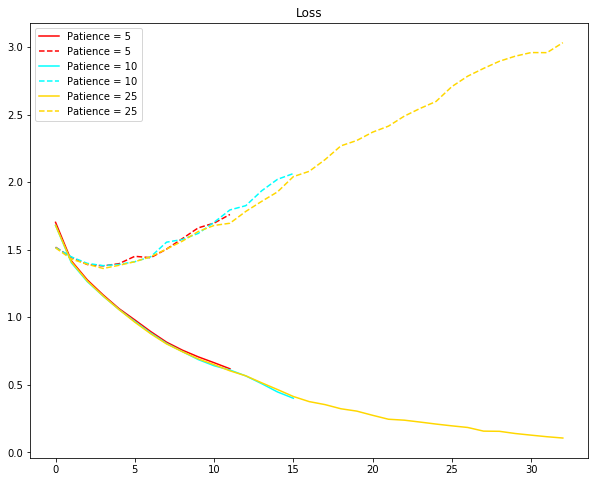

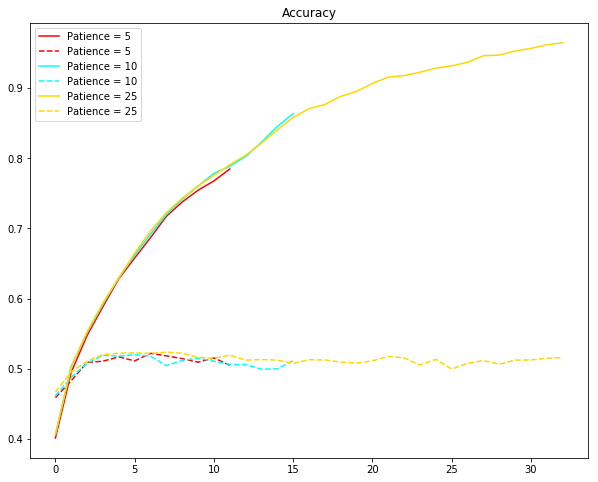

In [23]:
color_bar = ['red','aqua','gold']

plt.figure(figsize=(10, 8))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()